1. Make sure you have placed the 'To_Google_drive.zip' to your google drive (in root directory)
2. Make sure you have enabled the GPU in the 'Edit-->Notebook setting-->Hardware accelerator--> GPU'
3. Make sure you have enabled the High Ram in the 'Edit-->Notebook setting-->Runtime shape--> High-Ram'

# Imports

In [ ]:
import os.path
from os import path
from google.colab import drive
import torch
from IPython.display import Image
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import imgaug.augmenters as iaa
from tensorflow.keras.models import load_model

In [ ]:
# Mount the google drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
# Getting the "To_Google_drive.zip" that contains images and models.
!unzip -q /mydrive/To_Google_drive.zip -d ./

In [ ]:
# Cloning a yolov5 model.
!git clone https://github.com/ultralytics/yolov5 -qq
!pip install -U -r yolov5/requirements.txt -qq

%cd /content/yolov5

     |████████████████████████████████| 11.2 MB 4.1 MB/s 
     |████████████████████████████████| 60.5 MB 58 kB/s 
     |████████████████████████████████| 4.3 MB 43.2 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 5.8 MB 41.1 MB/s 
     |████████████████████████████████| 930 kB 41.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 w

# Combining the YOLO and CNN models to a complete system

## Visualizing the custom test images


In [ ]:
"""
Reading the custom created testing images
"""

# Read paths
paths_to_testing_images = glob.glob("/content/To_Google_drive/test_words/*jpg")
print(paths_to_testing_images)

# Read images from path
testing_images = []
for path_to_testing_image in paths_to_testing_images:
  testing_images.append(cv2.imread(path_to_testing_image))

# Print shape
testing_images = np.array(testing_images)
print(testing_images.shape)

['/content/To_Google_drive/test_words/0.jpg', '/content/To_Google_drive/test_words/2.jpg', '/content/To_Google_drive/test_words/1.jpg']
(3, 608, 608, 3)


In [ ]:
# Install older matplotlib because the new is defect
!pip install matplotlib==3.1.3 -qq

     |████████████████████████████████| 13.1 MB 4.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


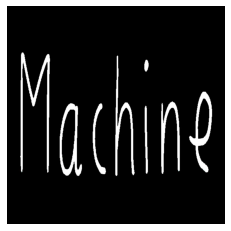

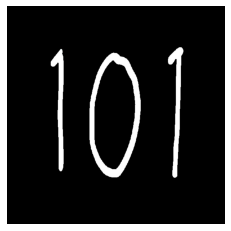

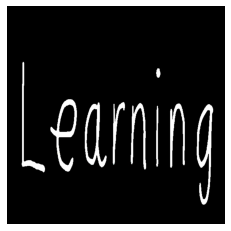

In [ ]:
"""
Visualizing the custom testing images
"""

# Function to plot an image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Plot every image
for image in testing_images:
  plot_image(image)

## Detecting characters

In [ ]:
# Install new matplotlib to satisfy YOLOv5 requirements
!pip install matplotlib==3.2.2 -qq

     |████████████████████████████████| 12.4 MB 4.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
"""
Detect characters in the custom test images using the weight I trained
"""

# Run detect
!python detect.py --save-txt --weights /content/To_Google_drive/yolo_trained_weights/best.pt --img 608 --conf 0.7 --source /content/To_Google_drive/test_words

detect: weights=['/content/To_Google_drive/yolo_trained_weights/best.pt'], source=/content/To_Google_drive/test_words, data=data/coco128.yaml, imgsz=[608, 608], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-174-gc4cb7c6 torch 1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/3 /content/To_Google_drive/test_words/0.jpg: 608x608 5 characters, Done. (0.376s)
image 2/3 /content/To_Google_drive/test_words/1.jpg: 608x608 7 characters, Done. (0.356s)
image 3/3 /content/To_Google_drive/test_words/2.jpg: 608x608 3 characters, Done. (0.639s)
Speed: 2.8ms pre-process, 457.2ms inference, 3.7ms NMS per image at shape (1, 3, 608, 608)


/content/yolov5/runs/detect/exp/*jpg


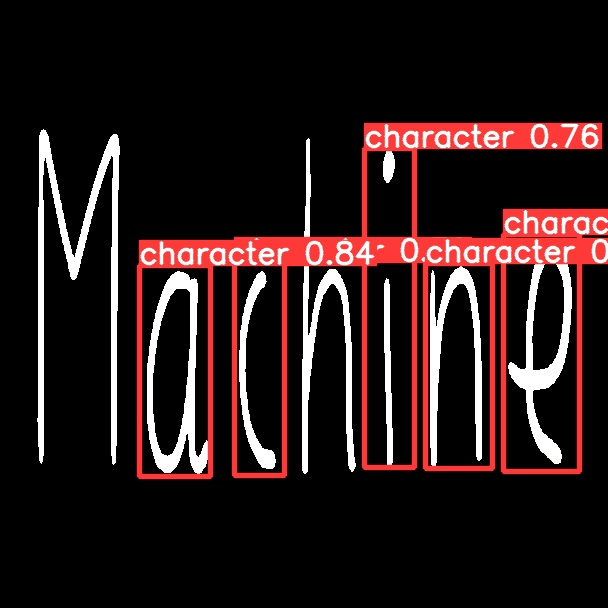

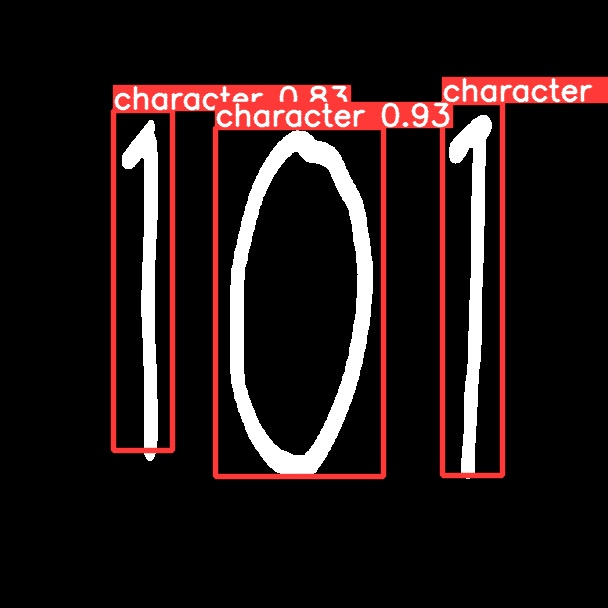

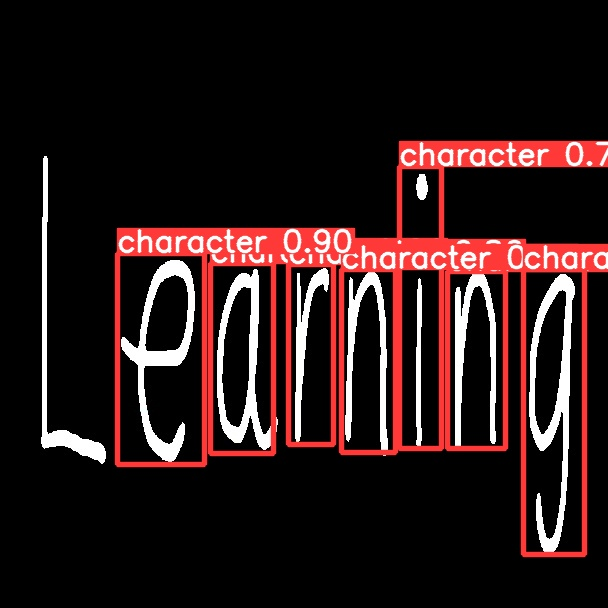

In [ ]:
"""
Visualize the detected words
"""


# Find the last detection output
outputs = glob.glob("/content/yolov5/runs/detect/*")
last_output = outputs[len(outputs)-1] + "/*jpg"
print(last_output)

# Visualize the detections
for imageName in glob.glob(last_output):
  display(Image(filename=imageName))
  print("\n")

## Converting detected character annotations to images for the CNN

In [ ]:
# Install older matplotlib because the new is defect
!pip install matplotlib==3.1.3 -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
"""
Getting labels (bounding boxes) and images
"""

# Label paths
outputs = sorted(glob.glob("/content/yolov5/runs/detect/*"))
labels_folder_path = outputs[len(outputs)-1] + "/labels/*"
labels_paths = glob.glob(labels_folder_path)

names = []
label_dict = {}
for label_path in labels_paths:
    # Read label file
    label = pd.read_csv(label_path, sep=" ", header=None)
    label = label.drop(0, axis=1)  # Dropping the object detection class name
    label = label.to_numpy()

    # Get name of label file
    label_name = label_path.split("/")[-1]
    label_name = label_name.split(".txt")[0]
    names.append(label_name) # Add to names list

    # Add to dictionary
    label_dict[label_name] = label


image_dict = {}
for image_path in paths_to_testing_images:
    # Read image file
    image = cv2.imread(image_path, 0)

    # Get name of image file
    image_name = image_path.split("/")[-1]
    image_name = image_name.split(".jpg")[0]

    # Add to dictionary
    image_dict[image_name] = image

Number of character images: 15
First image:


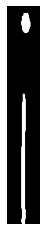

In [ ]:
"""
Cropping bounding boxes out of images
"""

# Function that formats coordinates from annotation
def format_coordinates(bounding_box, img_width, img_height):
    x = bounding_box[0]
    y = bounding_box[1]
    w = bounding_box[2]
    h = bounding_box[3]

    x_min = ((2 * x * img_width) - (w * img_width)) / 2
    x_max = ((2 * x * img_width) + (w * img_width)) / 2
    y_min = ((2 * y * img_height) - (h * img_height)) / 2
    y_max = ((2 * y * img_height) + (h * img_height)) / 2

    return x_min, x_max, y_min, y_max

# Crop images from the bounding box labels
new_images = []
for name in names:
    image = image_dict[name]
    label = label_dict[name]
    i = 0
    for bounding_box in label:
        i += 1
        # Coordinates formated
        x_min, x_max, y_min, y_max = format_coordinates(bounding_box, image.shape[1], image.shape[0])
        # Crop bounding box from image
        new_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
        # Add to new images list
        new_images.append(new_image)

print("Number of character images:",len(new_images))

# Function that plots a single image
def plot_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()


# Plot first image
print("First image:")
plot_image(new_images[0])

(15, 128, 128)
First image:


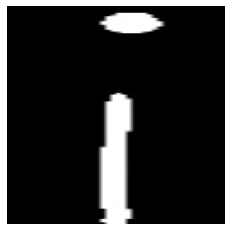

In [ ]:
"""
Resize the images to be the size that the CNN model expects
"""

# Function that resizes images to 128x128
def resize(images):
  images_128 = []
  for image in images:
      new_image = cv2.resize(image, (128, 128))
      images_128.append(new_image)
  return np.array(images_128)

# Resize images
images_v1 = resize(new_images)
print(images_v1.shape)

# Plot 1 image
print("First image:")
plot_image(images_v1[0])

First image:


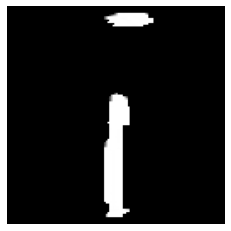

In [ ]:
"""
Erode images to make them thinner soo they are more similar the training data. Custom made
"""


# Custom made erotion function
def erotion(image, iterations): # Must recieve a 1 channel image
    # Create kernel
    kernel = [[0,0,0],[0,1,1],[1,1,1]]
    kernel_size = len(kernel)

    # Add padding
    padding = 1
    padded_image = np.zeros((image.shape[0]+(padding*2), image.shape[1]+(padding*2)), dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            padded_image[i+padding, j+padding] = image[i,j]

    # Erotion
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # If point is 1, check if surrounding are not 0 where the kernel is 1. If so, change the point to be 0
            if padded_image[i+padding, j+padding] != 0:
                # Cut out area of image that will be checked
                area_of_interest = padded_image[i:i+kernel_size, j:j+kernel_size]
                apply = False
                # If any index in kernel is 1 and at the same index 1 in area of interest, apply erotion
                for row_area, row_kernel in zip(area_of_interest, kernel):
                    for value_area, value_kernel in zip(row_area, row_kernel):
                        if value_kernel == 1 and value_area == 0:
                            apply = True
                if apply: # Apply erotion if true
                    padded_image[i+padding, j+padding] = 0

    # Remove padding
    image = padded_image[padding:padded_image.shape[0]-padding, padding:padded_image.shape[1]-padding]

    if iterations > 1:
      image = erotion(image, iterations-1)
    return image

# Extra function to keep the depth of the image
def erode(image, iteration):
  image_eroded = erotion(image, iteration)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      image[i, j] = image_eroded[i, j]
  return image


images_v2 = []
for image in images_v1:
  images_v2.append(erode(image, 4))
images_v2 = np.array(images_v2)


# Print first image
print("First image:")
plot_image(images_v2[0])


First image:


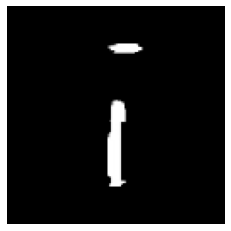

In [ ]:
"""
The characters are taking up the entire picture because of the detection. Zoom out to be more similar to training data
"""

# Zoom out
images_v3 = []
for image in images_v2:
  image_aug = iaa.Affine(scale=0.7)(image=image) # Zoom out
  images_v3.append(image_aug)

# Print first image
print("First image:")
plot_image(images_v3[0])

In [ ]:
"""
Reshape channels to fit the CNN model requirements
"""

 # Function that reshapes images to 3 channels
def reshape_channels(images):
  three_channels = []
  for image in images:
    three_channels.append(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB))
  return np.array(three_channels)

# Reshape images
images_v4 = reshape_channels(images_v3)
print(images_v4.shape)


(15, 128, 128, 3)


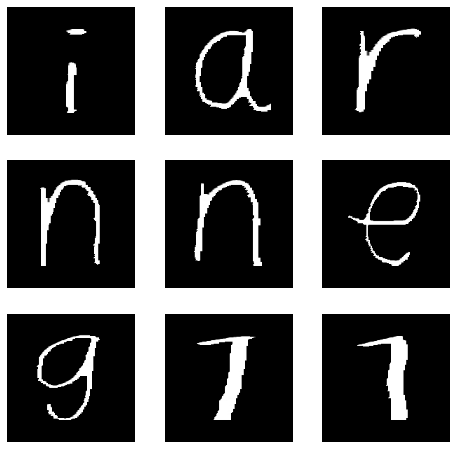

In [ ]:
"""
View images after all the changes made
"""

# Plot 9 character images
plt.figure(figsize=(8, 8))
for index, image in enumerate(images_v4):
    if index == 9:
      break
    plt.subplot(3, 3, index+1)
    plt.imshow(image)
    plt.axis('off')

In [ ]:
# Rename
images = images_v4
print(images.shape)

## Passing the detected character to the CNN model for classification

In [ ]:
"""
Load the model I trained
"""

# Loading the trained model
model = load_model("/content/To_Google_drive/cnn_trained_model/CNN_trained_model.h5")
# Viewing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 80)                655440    
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 62)                3162      
                                                                 
Total params: 15,377,340
Trainable params: 662,652
Non-trainable params: 14,714,688
_________________________________________________________________


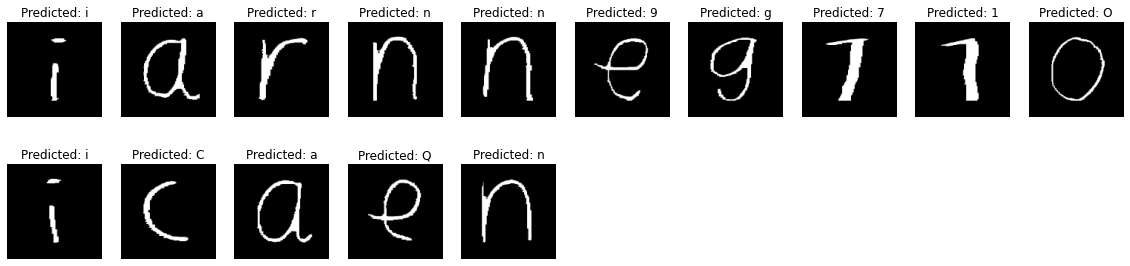

In [ ]:
"""
Predict on the detected images
"""

# Id for labels
label_id = {"0":"0", "1":"1", "2":"2", "3":"3", "4":"4", "5":"5", "6":"6", "7":"7", "8":"8", "9":"9", "10":"A",
            "11":"B", "12":"C", "13":"D", "14":"E", "15":"F", "16":"G", "17":"H", "18":"I", "19":"J", "20":"K",
            "21":"L", "22":"M", "23":"N", "24":"O", "25":"P", "26":"Q", "27":"R", "28":"S", "29":"T", "30":"U",
            "31":"V", "32":"W", "33":"X", "34":"Y", "35":"Z", "36":"a", "37":"b", "38":"c", "39":"d", "40":"e",
            "41":"f", "42":"g", "43":"h", "44":"i", "45":"j", "46":"k", "47":"l", "48":"m", "49":"n", "50":"o",
            "51":"p", "52":"q", "53":"r", "54":"s", "55":"t", "56":"u", "57":"v", "58":"w", "59":"x", "60":"y",
            "61":"z" }

# Do prediction on the images
prediction = model.predict(images)

# Format predictions using the label_id dictionary
predicted_formated = []
for row in prediction:
  predicted = np.argmax(row)
  predicted_formated.append(label_id[str(predicted)])

# Plotting the predictios with their images
plt.figure(figsize=(20, 10))
for index, image in enumerate(images):
    plt.subplot(4, 10, index+1)
    plt.imshow(image)
    plt.title("Predicted: "+predicted_formated[index])
    plt.axis('off')